In [1]:
import tensorflow as tf
import tensorflow_datasets as tfd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import random

In [2]:
# Hyperparameters settings(data)
unlabeled_ds = 100000
labeled_ds = 5000
image_size = 96
image_channels = 3

# Hyperparameters settings(algorithm)
batch_size = 1050  # Corresponds to 100 steps per epoch
epoch = 40
width = 128
temperature = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.5, "scale":(0.3,0.3), "ratio":(3/4,4/3), "stddev":0.08, "contrast":0.6, "hue":0.6, "saturation":0.6}
classification_augmentation = {"min_area": 0.80, "brightness": 0.2, "jitter": 0.2, "scale":(0.5,1), "ratio":(3/4,4/3), "stddev":0.02, "contrast":0.2, "hue":0.2, "saturation":0.3}

In [3]:
def build_ds():
    # Labeled and unlabeled samples are loaded synchronously
    # with batch sizes selected accordingly
    steps_per_epoch = (unlabeled_ds + labeled_ds) // batch_size
    unlabeled_batch_size = unlabeled_ds // steps_per_epoch
    labeled_batch_size = labeled_ds // steps_per_epoch
    print(f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)")

    unlabeled_train_ds = (tfd.load("stl10", split="unlabelled", as_supervised=True, shuffle_files=True)
                          .shuffle(buffer_size=10 * unlabeled_batch_size)
                          .batch(unlabeled_batch_size))
    
    labeled_train_ds = (tfd.load("stl10", split="train", as_supervised=True, shuffle_files=True)
                        .shuffle(buffer_size=10 * labeled_batch_size)
                        .batch(labeled_batch_size))
    
    test_ds = (tfd.load("stl10", split="test", as_supervised=True)
               .batch(batch_size))
               #.prefetch(buffer_size=tf.data.AUTOTUNE))

    # Labeled and unlabeled datasets are zipped together
    train_ds = tf.data.Dataset.zip((unlabeled_train_ds, labeled_train_ds))#.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, labeled_train_ds, test_ds


# Load STL10 dataset
train_ds, labeled_train_ds, test_ds  = build_ds()

batch size is 1000 (unlabeled) + 50 (labeled)


In [4]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, size, scale, ratio, **kwargs):
        super().__init__(**kwargs)
        # area-range of the cropped part: (min area, max area), uniform sampling
        self.scale = scale
        self.size = size
        # aspect-ratio-range of the cropped part: (log min ratio, log max ratio), log-uniform sampling
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]
            height = tf.shape(images)[1]
            width = tf.shape(images)[2]

            # independently sampled scales and ratios for every image in the batch
            random_scales = tf.random.uniform(
                (batch_size,), self.scale[0], self.scale[1]
            )
            random_ratios = tf.exp(
                tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
            )

            # corresponding height and widths, clipped to fit in the image
            new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
            new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)

            # random anchors for the crop bounding boxes
            height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
            width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

            # assemble bounding boxes and crop
            bounding_boxes = tf.stack(
                [
                    height_offsets,
                    width_offsets,
                    height_offsets + new_heights,
                    width_offsets + new_widths,
                ],
                axis=1,
            )
            images = tf.image.crop_and_resize(
                images, bounding_boxes, tf.range(batch_size), (height, width)
            )

        return images

class RandomGaussianNoise(layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, images, training=True):
        if training:
            images = tf.clip_by_value(
                images + tf.random.normal(tf.shape(images), stddev=self.stddev), 0, 1
            )
        return images


class RandomColorJitter(layers.Layer):
    def __init__(self, brightness, contrast, saturation, hue, **kwargs):
        super().__init__(**kwargs)

        # color jitter ranges: (min jitter strength, max jitter strength)
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

        # list of applicable color augmentations
        self.color_augmentations = [
            self.random_brightness,
            self.random_contrast,
            self.random_saturation,
            self.random_hue,
        ]

        # the tf.image.random_[brightness, contrast, saturation, hue] operations
        # cannot be used here, as they transform a batch of images in the same way

    def blend(self, images_1, images_2, ratios):
        # linear interpolation between two images, with values clipped to the valid range
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)

    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness
            ),
        )

    def random_contrast(self, images):
        # random interpolation/extrapolation between the image and its mean intensity value
        mean = tf.reduce_mean(
            tf.image.rgb_to_grayscale(images), axis=(1, 2), keepdims=True
        )
        return self.blend(
            images,
            mean,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.contrast, 1 + self.contrast
            ),
        )

    def random_saturation(self, images):
        # random interpolation/extrapolation between the image and its grayscale counterpart
        return self.blend(
            images,
            tf.image.rgb_to_grayscale(images),
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.saturation, 1 + self.saturation
            ),
        )

    def random_hue(self, images):
        # random shift in hue in hsv colorspace
        images = tf.image.rgb_to_hsv(images)
        images += tf.random.uniform(
            (tf.shape(images)[0], 1, 1, 3), (-self.hue, 0, 0), (self.hue, 0, 0)
        )
        # tf.math.floormod(images, 1.0) should be used here, however in introduces artifacts
        images = tf.where(images < 0.0, images + 1.0, images)
        images = tf.where(images > 1.0, images - 1.0, images)
        images = tf.image.hsv_to_rgb(images)
        return images

    def call(self, images, training=True):
        if training:
            # applies color augmentations in random order
            for color_augmentation in random.sample(self.color_augmentations, 4):
                images = color_augmentation(images)
        return images


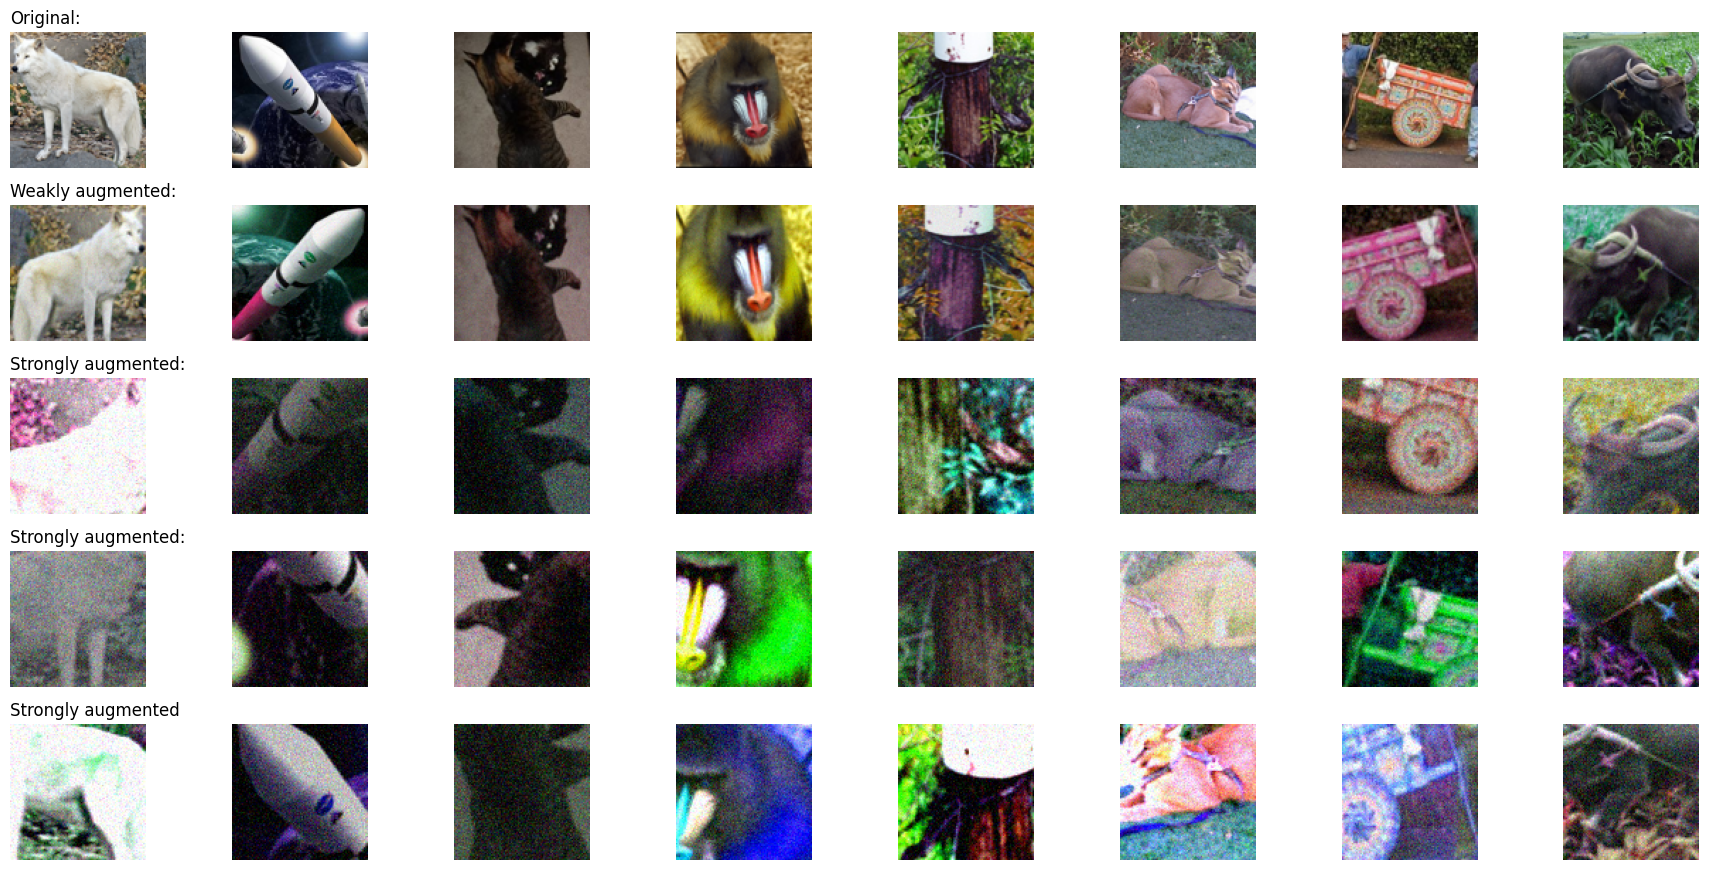

In [5]:


# Image augmentation module
def augmenter(min_area,brightness, jitter,scale,ratio,stddev,contrast,hue,saturation):

    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            preprocessing.Rescaling(1 / 255),
            preprocessing.RandomFlip("horizontal"),
            #preprocessing.RandomFlip("vertical"),
            #preprocessing.RandomTranslation(zoom_factor / 2, zoom_factor / 2, fill_mode='wrap', interpolation='bilinear'),
            # RandomColorAffine(brightness, jitter),
            RandomResizedCrop(64, scale, ratio),
            RandomColorJitter(brightness, contrast, saturation, hue),
            RandomGaussianNoise(stddev)
        ]

    )


def augmented_images(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_ds))[0][0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        images,
        augmenter(**classification_augmentation)(images),
        augmenter(**contrastive_augmentation)(images),
        augmenter(**contrastive_augmentation)(images),
        augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
        "Strongly augmented",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(5, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


augmented_images(num_images=8)

In [6]:
# Define the encoder architecture
def encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu", padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid", data_format=None,),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu", padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid", data_format=None,),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu", padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid", data_format=None,),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu", padding='same'),
           
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

In [7]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        augmenter(**classification_augmentation),
        encoder(),
        layers.Dense(20),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(labeled_train_ds, epochs=epoch, validation_data=test_ds)

print("Maximal validation accuracy: {:.2f}%".format(max(baseline_history.history["val_acc"]) * 100))

Epoch 1/40
100/100 [==============================] - 13s 109ms/step - loss: 2.3870 - acc: 0.0958 - val_loss: 2.3324 - val_acc: 0.1000
Epoch 2/40
100/100 [==============================] - 8s 76ms/step - loss: 2.2167 - acc: 0.1540 - val_loss: 2.0391 - val_acc: 0.2362
Epoch 3/40
100/100 [==============================] - 8s 76ms/step - loss: 1.9824 - acc: 0.2370 - val_loss: 1.7615 - val_acc: 0.3360
Epoch 4/40
100/100 [==============================] - 8s 76ms/step - loss: 1.9063 - acc: 0.2856 - val_loss: 1.7685 - val_acc: 0.3347
Epoch 5/40
100/100 [==============================] - 8s 75ms/step - loss: 1.8083 - acc: 0.3076 - val_loss: 1.6784 - val_acc: 0.3604
Epoch 6/40
100/100 [==============================] - 8s 76ms/step - loss: 1.7738 - acc: 0.3320 - val_loss: 1.6362 - val_acc: 0.3554
Epoch 7/40
100/100 [==============================] - 8s 79ms/step - loss: 1.7373 - acc: 0.3450 - val_loss: 1.6035 - val_acc: 0.3961
Epoch 8/40
100/100 [==============================] - 8s 76ms/step 

SimCLR

In [8]:
import tensorflow as tf

from abc import abstractmethod
from tensorflow import keras


class ContrastiveModel(keras.Model):
    def __init__(
        self,
        contrastive_augmenter,
        classification_augmenter,
        encoder,
        projection_head,
        linear_probe,
    ):
        super().__init__()

        self.contrastive_augmenter = augmenter(0.25,0.6,0.5,(1.5,2),(3/4,4/3),0.08,0.6,0.6,0.6)
        self.classification_augmenter = augmenter(0.80,0.2,0.2,(1.5,3),(2/3,3/2),0.02,0.2,0.2,0.3)
        self.encoder = encoder
        self.projection_head = projection_head
        self.linear_probe = linear_probe

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy()

    def reset_metrics(self):
        self.contrastive_accuracy.reset_states()
        self.probe_accuracy.reset_states()

    def update_contrastive_accuracy(self, projections_1, projections_2):
        # cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = tf.matmul(projections_1, projections_2, transpose_b=True)

        # the similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0),
        )

    
    def contrastive_loss(self, projections_1, projections_2):
        pass

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)
        with tf.GradientTape() as tape:
            # the representations are passed through a projection mlp
            projections_1 = self.projection_head(self.encoder(augmented_images_1))
            projections_2 = self.projection_head(self.encoder(augmented_images_2))
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.update_contrastive_accuracy(projections_1, projections_2)

        preprocessed_images = self.classification_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features = self.encoder(preprocessed_images)
            class_logits = self.linear_probe(features)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_accuracy.update_state(labels, class_logits)

        return {
            "c_loss": contrastive_loss,
            "c_acc": self.contrastive_accuracy.result(),
            "p_loss": probe_loss,
            "p_acc": self.probe_accuracy.result(),
        }

    def test_step(self, data):
        labeled_images, labels = data

        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)

        self.probe_accuracy.update_state(labels, class_logits)
        return {"p_loss": probe_loss, "p_acc": self.probe_accuracy.result()}




In [9]:
class SimCLR(ContrastiveModel):
    def __init__(
        self,
        contrastive_augmenter,
        classification_augmenter,
        encoder,
        projection_head,
        linear_probe,
        temperature,
    ):
        super().__init__(
            contrastive_augmenter,
            classification_augmenter,
            encoder,
            projection_head,
            linear_probe,
        )
        self.temperature = temperature

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # the temperature-scaled similarities are used as logits for cross-entropy
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        loss = keras.losses.sparse_categorical_crossentropy(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0),
            from_logits=True,
        )
        return loss


In [10]:
Algorithm = SimCLR
hyperparams = {
    SimCLR: {"temperature": 0.1}
}

In [11]:
# architecture
model = Algorithm(
    #contrastive
    augmenter(0.25,0.6,0.5,(0.5,1),(3/4,4/3),0.08,0.6,0.6,0.6),
    #classification
    augmenter(0.80,0.2,0.2,(0.8,1.2),(2/3,3/2),0.02,0.2,0.2,0.3),

    
    encoder(),

    projection_head=keras.Sequential(
        [
            layers.Input(shape=(width,)),
            layers.Dense(width, activation="relu"),
            layers.Dense(width),
        ],
        name="projection_head",
    ),
    linear_probe=keras.Sequential(
        [
            layers.Input(shape=(width,)),
            layers.Dense(width, activation="relu"),
        ],
        name="linear_probe",
    ),
    **hyperparams[Algorithm],
)

In [12]:
# optimizers
model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

# run training
history = model.fit(train_ds, epochs=epoch, validation_data=test_ds)

Epoch 1/40
100/100 [==============================] - 122s 1s/step - c_loss: 3.0504 - c_acc: 0.3494 - p_loss: 4.7258 - p_acc: 0.0882 - val_p_loss: 4.5603 - val_p_acc: 0.1034
Epoch 2/40
100/100 [==============================] - 119s 1s/step - c_loss: 0.9391 - c_acc: 0.8986 - p_loss: 4.3707 - p_acc: 0.1023 - val_p_loss: 4.1357 - val_p_acc: 0.1259
Epoch 3/40
100/100 [==============================] - 118s 1s/step - c_loss: 0.6208 - c_acc: 0.9604 - p_loss: 3.9707 - p_acc: 0.1310 - val_p_loss: 3.7288 - val_p_acc: 0.1491
Epoch 4/40
100/100 [==============================] - 119s 1s/step - c_loss: 0.4849 - c_acc: 0.9795 - p_loss: 3.6018 - p_acc: 0.1512 - val_p_loss: 3.3802 - val_p_acc: 0.1701
Epoch 5/40
100/100 [==============================] - 117s 1s/step - c_loss: 0.4200 - c_acc: 0.9856 - p_loss: 3.2731 - p_acc: 0.1691 - val_p_loss: 3.0572 - val_p_acc: 0.1865
Epoch 6/40
100/100 [==============================] - 118s 1s/step - c_loss: 0.3786 - c_acc: 0.9895 - p_loss: 3.0396 - p_acc: 0.19